# Cats v/s Dogs Classification using a RestNet12 Convolutional Neural Network from scratch.

<b> In this project, we will create a convolutional neural networks with 12 deep layers to train and predict whether a inputted image contains a cat or a dog. We will also perform data normalization, regularization, hyperparameter tuning, and use activation functions. The dataset used is taken from kaggle. With the knowledge I accquired from jovian's Deep learning course, I have implemented this architecture from scratch. </b>

## Importing the Dependencies

I will use opendatasets library provided by jovian to download the zip file of the image dataset from kaggle. The link to the dataset is [link](https://www.kaggle.com/c/dogs-vs-cats/data).

In [1]:
!pip install opendatasets --quiet

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

I will make use of zipfile library to unzip/extract zipped images into a data folder that I will create using os.

In [3]:
import zipfile
import opendatasets as od
import os

In [4]:
from numpy import asarray
from PIL import Image

## Downloading the data

In [5]:
url = 'https://www.kaggle.com/c/dogs-vs-cats/data'
od.download(url)
# #download_url(url,'.')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: royalalbert
Your Kaggle Key: ··········


100%|██████████| 812M/812M [00:03<00:00, 229MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [6]:
# creating a new directory using mkdir
os.mkdir('data')

In [7]:
# using zipfile library to extract all compressed training images into data directory

with zipfile.ZipFile('dogs-vs-cats/train.zip', 'r') as z:
    z.extractall(path='data')

In [8]:
# using zipfile library to extract all compressed testing images into data directory


with zipfile.ZipFile('dogs-vs-cats/test1.zip', 'r') as z:
    z.extractall(path='data')

In [9]:
data_dir = 'data'
print(os.listdir(data_dir))

files = os.listdir(data_dir +"/train")
print(files[0:3])

['test1', 'train']
['dog.7990.jpg', 'dog.1007.jpg', 'cat.9539.jpg']


## Extracting classes, performing normalization and regularization on images

In [10]:
def parse_label(name):
  name = name.split('.')[0]
  return name

In [11]:
parse_label(files[10000])

'dog'

This way, we can get the labels for all images in the dataset.

We can clearly see that the class to which image belongs is written in the image's name.

In [12]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [13]:
def get_all_targets(path):
  files = [fname for fname in os.listdir(path) if fname.endswith('.jpg')]
  labels = list(set(parse_label(fname) for fname in files))
  return labels

target = get_all_targets(data_dir+'/train/')

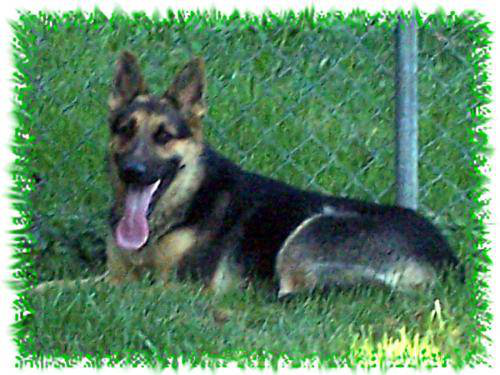

In [14]:
image = open_image('data/train/'+files[0])
image

In [15]:
class CatDogDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_label(fname) for fname in self.files))
        self.transform = transform
    
    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_label(fname))
        # labels = self.classes
        return img, class_idx#, labels

In [16]:
image_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transformer = T.Compose([T.Resize(224),  # resizing all images into 250*250 pixels 
                        T.Pad(10, padding_mode = 'reflect'),
                        T.RandomCrop(224),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean,std)])

In [17]:
# Applying the folloqing regularization and normalization into our dataset
data_dir = 'data/train/'
dataset = CatDogDataset(data_dir, transformer)

In [18]:
test_dir = 'data/test1/'

transformer = T.Compose([T.Resize((224,224)),  # resizing all images into 250*250 pixels 
                        T.ToTensor()])

test_dataset = CatDogDataset(test_dir, transformer)

In [19]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [20]:
len(dataset)

25000

In [21]:
len(test_dataset)

12500

In [22]:
target 

['dog', 'cat']

In [23]:
target = dataset.classes

In [24]:
img , class_idx = dataset[2]

In [25]:
img.shape

torch.Size([3, 224, 224])

In [26]:
class_idx

1

In [27]:
img

tensor([[[-0.2513, -0.2856, -0.2513,  ...,  1.1872,  1.2214,  1.2043],
         [ 0.5193,  0.4679,  0.5193,  ...,  1.3242,  1.3413,  1.2899],
         [ 0.4508,  0.4337,  0.4508,  ...,  0.3994,  0.3309,  0.2111],
         ...,
         [-0.8164,  0.4337, -0.8164,  ...,  0.9817,  0.1939, -0.6452],
         [-0.8678,  0.3652, -0.8678,  ...,  0.8618,  0.1254, -0.5938],
         [-0.8678,  0.3309, -0.8678,  ...,  0.6563,  0.1768, -0.6109]],

        [[ 0.0301, -0.0049,  0.0301,  ...,  1.5357,  1.5882,  1.5707],
         [ 0.8529,  0.8004,  0.8529,  ...,  1.6408,  1.6583,  1.6057],
         [ 0.8004,  0.7829,  0.8004,  ...,  0.6254,  0.5553,  0.4328],
         ...,
         [-0.4601,  0.8179, -0.4601,  ...,  1.0630,  0.2927, -0.5476],
         [-0.5126,  0.7479, -0.5126,  ...,  0.9580,  0.2227, -0.4776],
         [-0.5126,  0.7129, -0.5126,  ...,  0.7479,  0.2752, -0.4951]],

        [[-0.2184, -0.2532, -0.2184,  ...,  0.9668,  1.0191,  0.9842],
         [ 0.4962,  0.4439,  0.4962,  ...,  1

<b> We can use transforms method offered by torchvision to convert a image to a tensor </b>

import torchvision.transforms as T

img1 = T.Compose([T.ToTensor()])(img)



------------------------------------------------------------------------

tensor([[[0.2510, 0.2510, 0.2471,  ..., 0.7608, 0.7922, 0.7922],
         [0.2471, 0.2510, 0.2431,  ..., 0.7647, 0.7804, 0.7843],
         [0.2510, 0.2510, 0.2471,  ..., 0.7647, 0.7804, 0.7882],
         ...,
         [0.4275, 0.4392, 0.4549,  ..., 0.6118, 0.6000, 0.5922],
         [0.4510, 0.4588, 0.4588,  ..., 0.6275, 0.6157, 0.6000],
         [0.4784, 0.4784, 0.4745,  ..., 0.6431, 0.6353, 0.6392]],

        [[0.2392, 0.2392, 0.2431,  ..., 0.8392, 0.8627, 0.8549],
         [0.2353, 0.2392, 0.2392,  ..., 0.8431, 0.8510, 0.8471],
         [0.2392, 0.2392, 0.2431,  ..., 0.8431, 0.8510, 0.8549],
         ...,
         [0.2706, 0.2824, 0.2980,  ..., 0.4353, 0.4235, 0.4078],
         [0.2941, 0.3020, 0.3020,  ..., 0.4510, 0.4392, 0.4157],
         [0.3216, 0.3216, 0.3176,  ..., 0.4667, 0.4588, 0.4549]],

        [[0.3608, 0.3608, 0.3647,  ..., 0.9333, 0.9490, 0.9569],
         [0.3569, 0.3608, 0.3608,  ..., 0.9373, 0.9373, 0.9490],
         [0.3529, 0.3608, 0.3647,  ..., 0.9373, 0.9373, 0.9569],
         ...,
         [0.2314, 0.2431, 0.2588,  ..., 0.3529, 0.3412, 0.3373],
         [0.2549, 0.2627, 0.2627,  ..., 0.3686, 0.3569, 0.3451],
         [0.2824, 0.2824, 0.2784,  ..., 0.3843, 0.3765, 0.3843]]])

<b> Since we have normalized our images, and performed regularization on them, We will have to denormalize then back to view the images in their original form.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


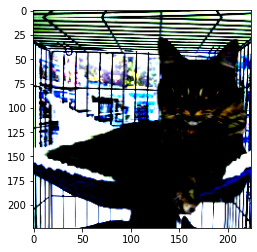

In [28]:
# this is our normalized image
plt.imshow(img.permute(1,2,0));

In [29]:
(img.shape)

torch.Size([3, 224, 224])

In [30]:
len(img[0])

224

<b> If a tensor has 1 dimension, then unsqueezing that array tensor adds an additional dimension into that original tensor. In the example below, a 1-d tensor has 4 elements. Then we unsqueeze it. Then, an additional dimension is addded into it. </b>

In [31]:
x = torch.tensor([1, 2, 3, 4])
x.shape

torch.Size([4])

In [32]:
x = x.unsqueeze(0)
x.shape

torch.Size([1, 4])

In [33]:
x

tensor([[1, 2, 3, 4]])

In [34]:
img

tensor([[[-0.2513, -0.2856, -0.2513,  ...,  1.1872,  1.2214,  1.2043],
         [ 0.5193,  0.4679,  0.5193,  ...,  1.3242,  1.3413,  1.2899],
         [ 0.4508,  0.4337,  0.4508,  ...,  0.3994,  0.3309,  0.2111],
         ...,
         [-0.8164,  0.4337, -0.8164,  ...,  0.9817,  0.1939, -0.6452],
         [-0.8678,  0.3652, -0.8678,  ...,  0.8618,  0.1254, -0.5938],
         [-0.8678,  0.3309, -0.8678,  ...,  0.6563,  0.1768, -0.6109]],

        [[ 0.0301, -0.0049,  0.0301,  ...,  1.5357,  1.5882,  1.5707],
         [ 0.8529,  0.8004,  0.8529,  ...,  1.6408,  1.6583,  1.6057],
         [ 0.8004,  0.7829,  0.8004,  ...,  0.6254,  0.5553,  0.4328],
         ...,
         [-0.4601,  0.8179, -0.4601,  ...,  1.0630,  0.2927, -0.5476],
         [-0.5126,  0.7479, -0.5126,  ...,  0.9580,  0.2227, -0.4776],
         [-0.5126,  0.7129, -0.5126,  ...,  0.7479,  0.2752, -0.4951]],

        [[-0.2184, -0.2532, -0.2184,  ...,  0.9668,  1.0191,  0.9842],
         [ 0.4962,  0.4439,  0.4962,  ...,  1

In [35]:
imgx = img.unsqueeze(0)
print(imgx.shape)

torch.Size([1, 3, 224, 224])


In [36]:
imgx

tensor([[[[-0.2513, -0.2856, -0.2513,  ...,  1.1872,  1.2214,  1.2043],
          [ 0.5193,  0.4679,  0.5193,  ...,  1.3242,  1.3413,  1.2899],
          [ 0.4508,  0.4337,  0.4508,  ...,  0.3994,  0.3309,  0.2111],
          ...,
          [-0.8164,  0.4337, -0.8164,  ...,  0.9817,  0.1939, -0.6452],
          [-0.8678,  0.3652, -0.8678,  ...,  0.8618,  0.1254, -0.5938],
          [-0.8678,  0.3309, -0.8678,  ...,  0.6563,  0.1768, -0.6109]],

         [[ 0.0301, -0.0049,  0.0301,  ...,  1.5357,  1.5882,  1.5707],
          [ 0.8529,  0.8004,  0.8529,  ...,  1.6408,  1.6583,  1.6057],
          [ 0.8004,  0.7829,  0.8004,  ...,  0.6254,  0.5553,  0.4328],
          ...,
          [-0.4601,  0.8179, -0.4601,  ...,  1.0630,  0.2927, -0.5476],
          [-0.5126,  0.7479, -0.5126,  ...,  0.9580,  0.2227, -0.4776],
          [-0.5126,  0.7129, -0.5126,  ...,  0.7479,  0.2752, -0.4951]],

         [[-0.2184, -0.2532, -0.2184,  ...,  0.9668,  1.0191,  0.9842],
          [ 0.4962,  0.4439,  

<b> The reason we added an additonal dimension into our original image tensor is because, while creating dataloaders, we will need to add the labels into each respective image tensor. So, an additional dimension will make sure that in a single array tensor, its first index element is another tensor with image tensors, and index 1 element is the label for the respective image. </b>

In [37]:
import numpy as np

In [38]:
np.array(mean).shape

(3,)

In [39]:
print(mean)
print(np.array(mean).shape)

[0.485, 0.456, 0.406]
(3,)


<b> In order to denormalize the images, we will need to apply mean and standard deviation by converting them into the appropriate dimensions as the image in the dataset is. </b>

In [40]:
np.array(mean).reshape(1,3)

array([[0.485, 0.456, 0.406]])

In [41]:
mean1 = np.array([1,2,3,4])

In [42]:
np.array(mean1).reshape(2,2)

array([[1, 2],
       [3, 4]])

In [43]:
mean = [0.485, 0.456, 0.406]

In [44]:
means = torch.tensor(mean).reshape(3, 1, 1)
means

tensor([[[0.4850]],

        [[0.4560]],

        [[0.4060]]])

In [45]:
means = torch.tensor(mean).reshape(1,3, 1, 1)
means

tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])

In [46]:
def denormalize_the_images(image, mean, std):
  if (len(image.shape) == 3):
    image = image.unsqueeze(0)
  mean = torch.tensor(mean).reshape(1,3,1,1) # image ta matrix tensor ma xa. so matrix multiply ra add garda shape eutai huna paryo nita
  std = torch.tensor(std).reshape(1,3,1,1)
  return image * std + mean

In [47]:
mean,std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [48]:
def displaying_image(img, label):
  print("Label is: ", label," or ",dataset.classes[label])
  denormalized_image_tensor = denormalize_the_images(img, mean, std)[0]
  plt.imshow(denormalized_image_tensor.permute(1,2,0))

Label is:  1  or  cat


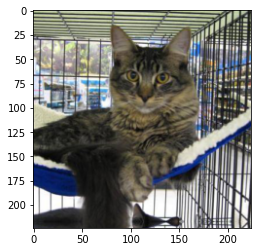

In [49]:
displaying_image(*dataset[2])

Label is:  1  or  cat


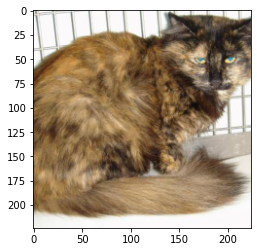

In [50]:
displaying_image(*dataset[20])

## Creating Training and Validation set

In [51]:
dataset[0]

(tensor([[[ 2.1633,  2.0263,  1.7352,  ..., -0.2684, -0.1314, -0.3027],
          [ 2.2318,  2.2147,  2.0948,  ...,  0.2111,  0.1426, -0.0458],
          [ 2.2489,  2.2489,  2.2489,  ...,  0.5707,  0.5022,  0.5193],
          ...,
          [ 1.5982,  1.1187,  0.8789,  ..., -1.1075, -0.5253,  0.6049],
          [ 1.9749,  2.0092,  2.0605,  ..., -1.5357, -1.2788, -0.9705],
          [ 2.1804,  2.1804,  1.8722,  ..., -1.6727, -1.8610, -1.2103]],
 
         [[ 2.3936,  2.4286,  2.4111,  ...,  1.2206,  1.6408,  1.6933],
          [ 2.3585,  2.3761,  2.3761,  ...,  1.6232,  1.7108,  1.6057],
          [ 2.3235,  2.2710,  2.3410,  ...,  1.8683,  1.7983,  1.7458],
          ...,
          [ 2.1835,  1.9559,  1.9034,  ...,  0.0651,  0.8704,  1.7633],
          [ 2.1485,  2.0434,  2.2360,  ...,  0.4853,  0.9755,  0.9755],
          [ 2.2885,  2.1485,  2.0609,  ...,  1.2206,  1.1506,  0.8529]],
 
         [[ 2.6400,  2.5529,  2.2566,  ...,  0.2173,  0.3219,  0.0953],
          [ 2.6400,  2.6226,

In [52]:
torch.manual_seed(42)

val_size = 5000 # we will use 5000 images from training set for validation

# using random_split to randomply seperat"e images into training and validation set
train_set, validation_set = random_split(dataset, [len(dataset)- val_size, val_size])

Label is:  0  or  dog


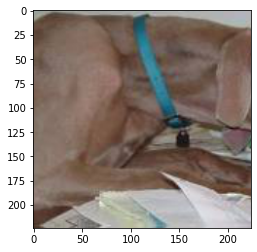

In [53]:
img , label = train_set[100]
displaying_image(img,label)

Label is:  0  or  dog


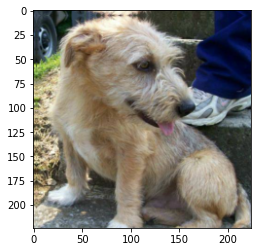

In [54]:
img , label = train_set[1000]
displaying_image(img,label)

Label is:  1  or  cat


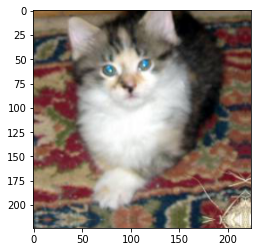

In [55]:
img , label = train_set[10000]
displaying_image(img,label)

In [56]:
len(train_set), len(validation_set)

(20000, 5000)

<b> Lets create the dataloaders for training and validation set </b>

In [57]:
batch_size = 256

train_dl = DataLoader(train_set, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(validation_set, batch_size*2, shuffle = True, pin_memory = True)

In [58]:
test_dl = DataLoader(test_dataset, batch_size*2, shuffle = True, pin_memory = True)

In [59]:
imgx.shape

torch.Size([1, 3, 224, 224])

In [60]:
std

[0.229, 0.224, 0.225]

images.shape: torch.Size([256, 3, 224, 224])


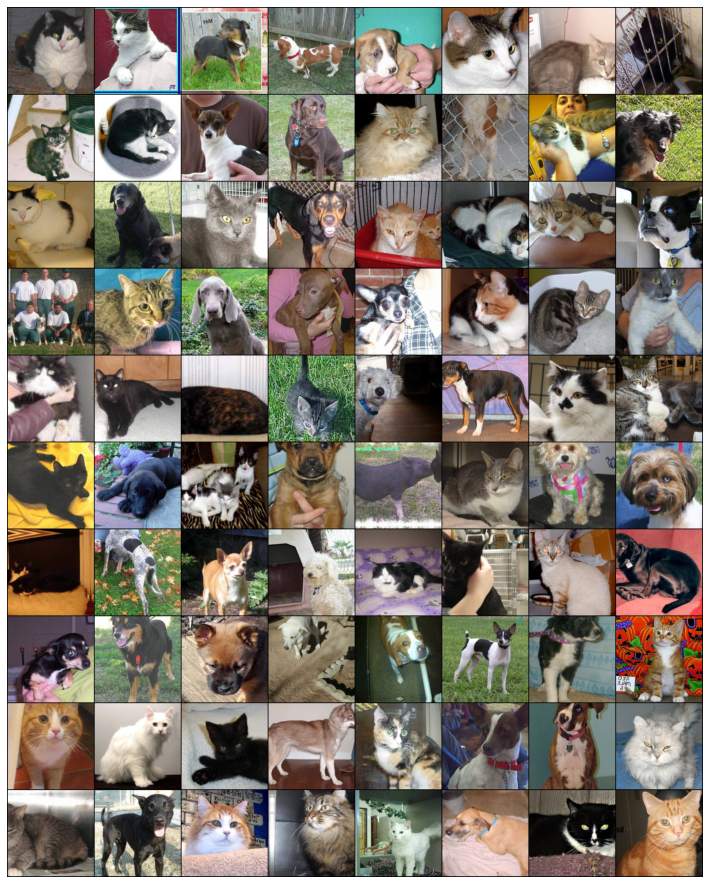

In [61]:
for images, _ in train_dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    images = denormalize_the_images(images[:80],mean,std)
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

## Creating a RestNet12 CNN Architecture From Scratch

In [62]:
# lets create our logistic regression model
input_size = 3 * 224 * 224
num_classes = 2

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct_outcomes = torch.sum(preds == labels).item()
    total_outcomes = len(labels)

    accuracy = torch.tensor(correct_outcomes / total_outcomes)
    return round((accuracy.item() * 100),3)

<b> Using cross entropy loss function for predicting our loss on our classification problem since we cant use accuracy for optimizing our model as it its developed for us humans for better understanding our model. </b>

### Lets define our helper functions and start predicting from our training and validation set, and optimize our model using stocastic gradient descent

In [64]:
# function of nn.dropout2d()

m = nn.Dropout2d(p=0.5)
input = torch.tensor([[20., 16, 32, 32]])
output = m(input)
output

tensor([[40., 32., 64., 64.]])

In [65]:
class CatDogClassifier(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.tensor(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.tensor(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))     
    

In [66]:
def conv_block(in_channels, out_channels, pool=False, dropout = False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    if dropout: layers.append(nn.Dropout2d(0.25))

    return nn.Sequential(*layers)

In [67]:
img_size = 224 * 224

In [71]:
"""
This is a ResNet17 Convolutional Neural Network that I created from scratch
"""

class ResNet17(CatDogClassifier):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # 1st convolutional layer that takes in image with size 224 * 224
        # 3 * 224 * 224
        self.conv1 = conv_block(in_channels, 4)
        # 4 * 224 * 224
        self.conv2 = conv_block(4,8)
        # 8 * 224 * 224
        self.conv3 = conv_block(8,16,pool = True)
        # 16 * 112 * 112
        self.residual_block1 = nn.Sequential(conv_block(16, 32, dropout = True),conv_block(32,16)) # conv layer 4
        # 16 * 112 * 112
        self.conv6 = conv_block(16,32, pool = True)
        # 32 * 56 * 56 
        self.residual_block2 = nn.Sequential(conv_block(32, 64, pool = False, dropout = False), conv_block(64,32))
        # 32 * 56 * 56
        self.conv9 = conv_block(32,64, pool = True)
        # 64 * 28 * 28
        self.residual_block3 = nn.Sequential(conv_block(64,128, pool = False, dropout = True),conv_block(128,64))
        # 128 * 28 * 28 ----------------------- # 64 * 28 * 28

        # input into linear layer 1 = # 1024 * 28 * 28
        self.five_linear_layers =  nn.Sequential(nn.Flatten(), 
                                           # 1st linear layer
                                           nn.Linear(64*28*28, 64),
                                           #nn.BatchNorm2d(64),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),                                           

                                           # 2nd linear layer
                                           nn.Linear(64,32),
                                           #nn.BatchNorm2d(32),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 3rd Linear Layer
                                           nn.Linear(32,16),
                                           #nn.BatchNorm2d(16),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 4th linear layer
                                           nn.Linear(16,8),
                                           #nn.BatchNorm2d(8),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),

                                           # 5th linear layer
                                           nn.Linear(8,4),
                                           #nn.BatchNorm2d(4),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout2d(0.2),
                                           )
        self.classifier = nn.Linear(4,num_classes)
        
        
    def forward(self, xb):
      out = self.conv1(xb)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.residual_block1(out) + out
      out = self.conv6(out)
      out = self.residual_block2(out) + out
      out = self.conv9(out)
      out = self.residual_block3(out) + out
      out = self.five_linear_layers(out)
      out = self.classifier(out)
      return out

In [72]:
model = ResNet17(3,2)
model

ResNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [69]:
# helper function to perform evaluation on validation and training sets

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [70]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [73]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    lr_rate_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            lr_rate_scheduler.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Using the GPU for Faster Training and Testing

In [74]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [75]:
device = get_default_device()
device

device(type='cuda')

model lai gpu ma train garna model lai matra haina teo data/ dataloaders lai ni eutai gpu ma lana parxa natra euta saman eta arko uta hunxa

In [76]:
train_dl1 = DeviceDataLoader(train_dl, device)
val_dl1 = DeviceDataLoader(val_dl, device)
test_dl1 = DeviceDataLoader(test_dl, device)

In [77]:
to_device(model, device)

ResNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block1): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [78]:
history = [evaluate(model, val_dl1)]

In [79]:
history

[{'val_acc': 49.63050079345703, 'val_loss': 0.725013017654419}]

<b> Since our model has randomly generated weights and biases, the initial validation accuracy is calculated to be approximately 50.5 %. This is so because there are only two classes. So, the probability of an event occurring is only 0.5. </b>

In [80]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.SGD

In [81]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dl1, val_dl1, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00081, train_loss: 0.7024, val_loss: 0.6803, val_acc: 57.6939
Epoch [1], last_lr: 0.00197, train_loss: 0.6840, val_loss: 0.6704, val_acc: 59.1881
Epoch [2], last_lr: 0.00370, train_loss: 0.6678, val_loss: 0.6424, val_acc: 63.6612
Epoch [3], last_lr: 0.00569, train_loss: 0.6524, val_loss: 0.6497, val_acc: 62.0417
Epoch [4], last_lr: 0.00759, train_loss: 0.6370, val_loss: 0.6126, val_acc: 63.7261
Epoch [5], last_lr: 0.00908, train_loss: 0.6089, val_loss: 0.5625, val_acc: 70.3655
Epoch [6], last_lr: 0.00989, train_loss: 0.5772, val_loss: 0.5052, val_acc: 76.5051
Epoch [7], last_lr: 0.00998, train_loss: 0.5559, val_loss: 0.7447, val_acc: 58.2647
Epoch [8], last_lr: 0.00982, train_loss: 0.5278, val_loss: 0.4610, val_acc: 77.4865
Epoch [9], last_lr: 0.00950, train_loss: 0.5035, val_loss: 0.4407, val_acc: 80.8286
Epoch [10], last_lr: 0.00905, train_loss: 0.5000, val_loss: 0.4353, val_acc: 81.6263
Epoch [11], last_lr: 0.00846, train_loss: 0.4714, val_loss: 0.4631, val_acc

In [82]:
torch.save(model.state_dict(), 'catvdog-stage1-valacc-stage2.pth')

In [83]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

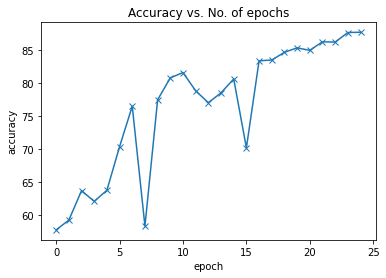

In [84]:
plot_accuracies(history)

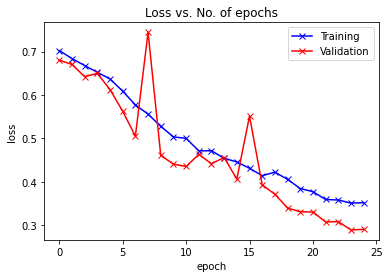

In [85]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

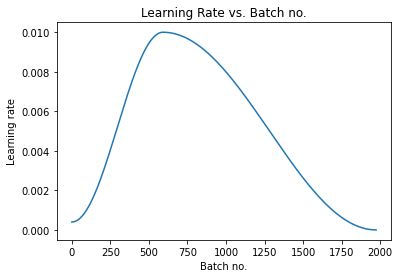

In [86]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)